## 1. Setup & Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
import lightgbm as lgb
!pip install optuna --quiet
import optuna
from optuna.visualization import plot_optimization_history
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 100)
%matplotlib inline

print('✓ All libraries imported successfully!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 10.3 MB/s eta 0:00:00
✓ All libraries imported successfully!


In [2]:
# Load datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Store IDs for submission
test_ids = test_df['Id'].copy()

print(f'📊 Training Set: {train_df.shape[0]} rows, {train_df.shape[1]} columns')
print(f'📊 Test Set: {test_df.shape[0]} rows, {test_df.shape[1]} columns')
print(f'\n💰 Target: SalePrice')
print(f'   Min: ${train_df["SalePrice"].min():,.0f}')
print(f'   Max: ${train_df["SalePrice"].max():,.0f}')
print(f'   Mean: ${train_df["SalePrice"].mean():,.0f}')

📊 Training Set: 1460 rows, 81 columns
📊 Test Set: 1459 rows, 80 columns

💰 Target: SalePrice
   Min: $34,900
   Max: $755,000
   Mean: $180,921


In [3]:
# Preview the data
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


---
## 2. Exploratory Data Analysis (EDA)
### 2.1 Target Variable: SalePrice

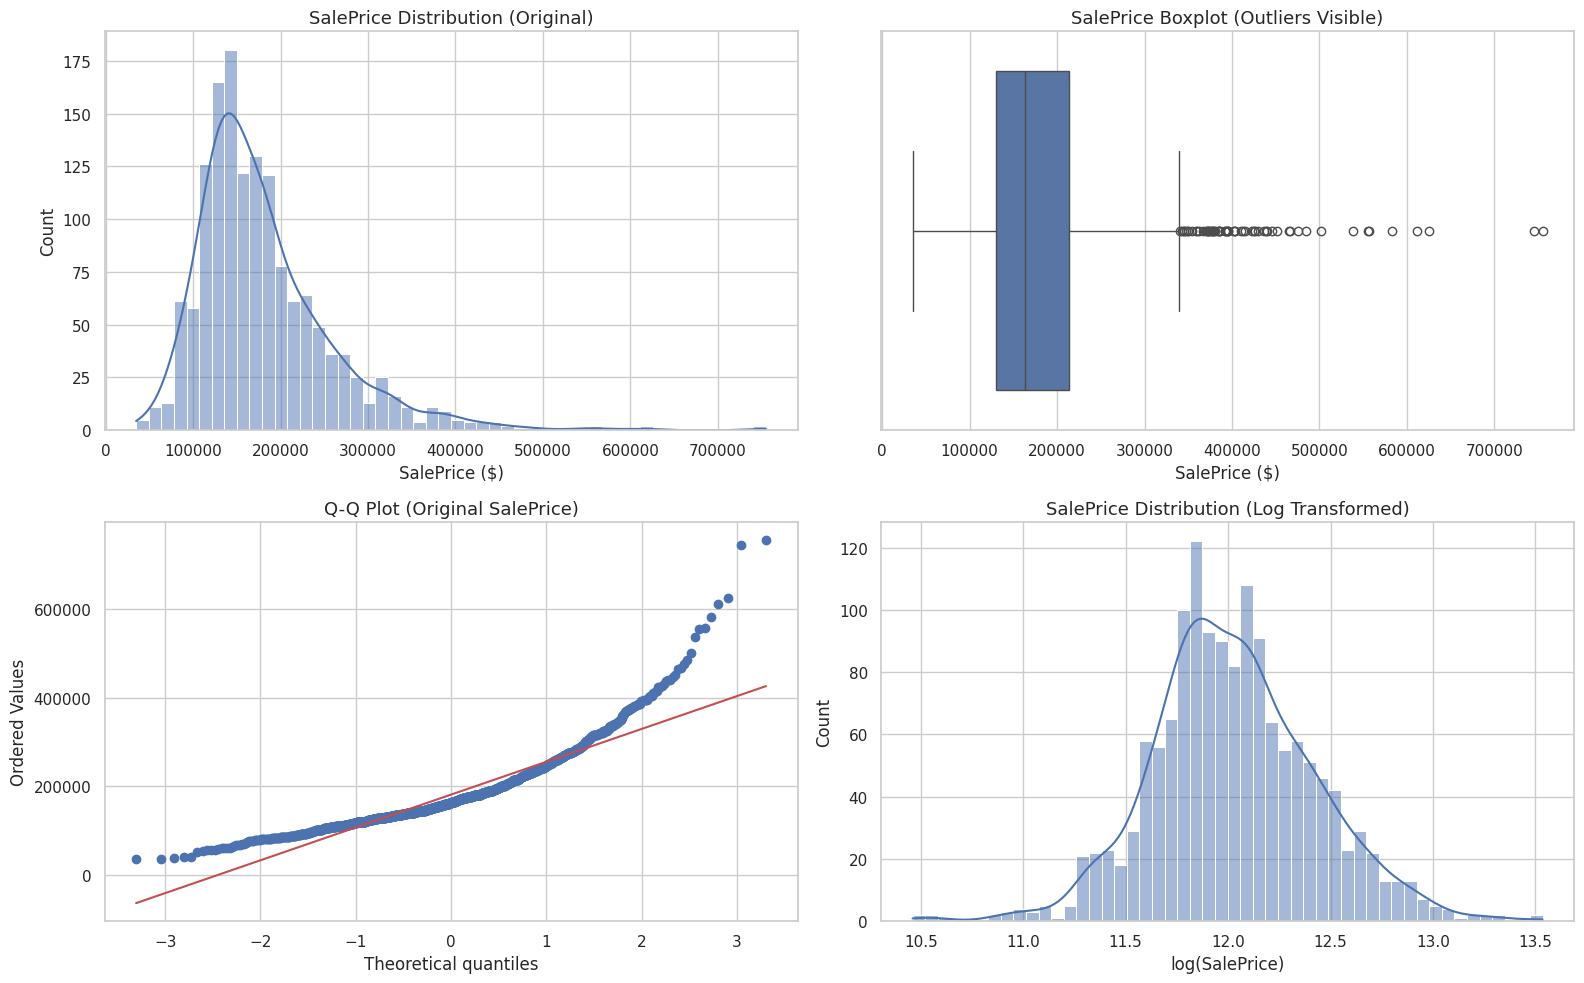

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histogram + KDE (Original)
sns.histplot(
    train_df['SalePrice'],
    bins=50,
    kde=True,
    ax=axes[0, 0]
)
axes[0, 0].set_title('SalePrice Distribution (Original)', fontsize=13)
axes[0, 0].set_xlabel('SalePrice ($)')
axes[0, 0].set_ylabel('Count')

# 2. Boxplot (Original)
sns.boxplot(
    x=train_df['SalePrice'],
    ax=axes[0, 1]
)
axes[0, 1].set_title('SalePrice Boxplot (Outliers Visible)', fontsize=13)
axes[0, 1].set_xlabel('SalePrice ($)')

# 3. Q-Q Plot (Original)
stats.probplot(train_df['SalePrice'], plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Original SalePrice)', fontsize=13)

# 4. Histogram after Log Transform
log_price = np.log1p(train_df['SalePrice'])

sns.histplot(
    log_price,
    bins=50,
    kde=True,
    ax=axes[1, 1]
)
axes[1, 1].set_title('SalePrice Distribution (Log Transformed)', fontsize=13)
axes[1, 1].set_xlabel('log(SalePrice)')

plt.tight_layout()
plt.show()


### 2.2 Missing Values Analysis

In [5]:
# Combine datasets for consistent preprocessing
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df['SalePrice'].values

all_data = pd.concat([train_df.drop('SalePrice', axis=1), test_df], axis=0, ignore_index=True)
print(f'Combined data shape: {all_data.shape}')

# Calculate missing values
missing = all_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(all_data)) * 100

# Display missing values
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct.round(2)
})
print(f'\n🔍 Features with missing values: {len(missing_df)}')


missing_df.head(15)

Combined data shape: (2919, 80)

🔍 Features with missing values: 34


,Missing Count,Missing %
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
MasVnrType,1766,60.50
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageCond,159,5.45


In [7]:
import plotly.express as px

# Prepare data
top_missing = missing_pct.sort_values(ascending=False).head(20)
df_missing = top_missing.reset_index()
df_missing.columns = ['Feature', 'MissingPercentage']

# Interactive horizontal bar chart
fig = px.bar(
    df_missing,
    x='MissingPercentage',
    y='Feature',
    orientation='h',
    text='MissingPercentage',  # shows value on hover and bars
    color='MissingPercentage',
    color_continuous_scale='Blues_r',
    labels={'MissingPercentage': 'Missing %', 'Feature': 'Feature'},
    title='📊 Top 20 Features with Highest Missing Values'
)

# Invert y-axis to have highest missing on top
fig.update_yaxes(categoryorder='total ascending')

# Customize layout
fig.update_layout(
    template='plotly_white',
    xaxis_title='Missing Percentage (%)',
    yaxis_title='Features',
    font=dict(size=13),
    margin=dict(l=120, r=40, t=80, b=60),
    coloraxis_showscale=False
)

# Add hover info formatting
fig.update_traces(
    hovertemplate='<b>%{y}</b><br>Missing: %{x:.1f}%',
    texttemplate='%{x:.1f}%',
    textposition='outside'
)

# Show interactive plot
fig.show()


### 2.3 Correlation Analysis

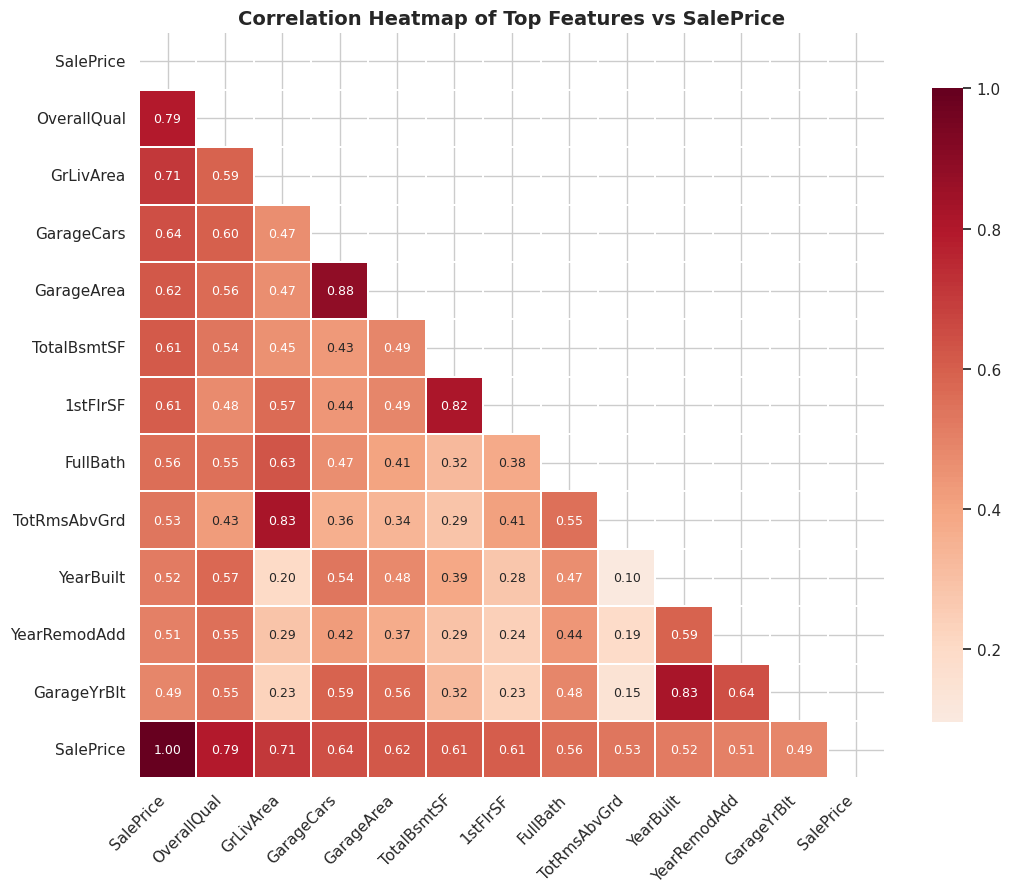

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation with SalePrice, only considering numeric columns
corr = train_df.corr(numeric_only=True)['SalePrice']

# Select top features by absolute correlation with SalePrice
top_features = (
    corr
    .abs()
    .sort_values(ascending=False)
    .head(12)
    .index
    .tolist()
)
top_features.append("SalePrice")

# Correlation matrix (now operating on a subset guaranteed to be numeric)
corr_matrix = train_df[top_features].corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot
plt.figure(figsize=(11, 9))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="RdBu_r",          # balanced, industry standard
    center=0,
    square=True,
    linewidths=0.3,        # subtle separation
    cbar_kws={"shrink": 0.85},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9}
)

plt.title(
    "Correlation Heatmap of Top Features vs SalePrice",
    fontsize=14,
    weight="bold"
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### 2.4 Key Features vs SalePrice

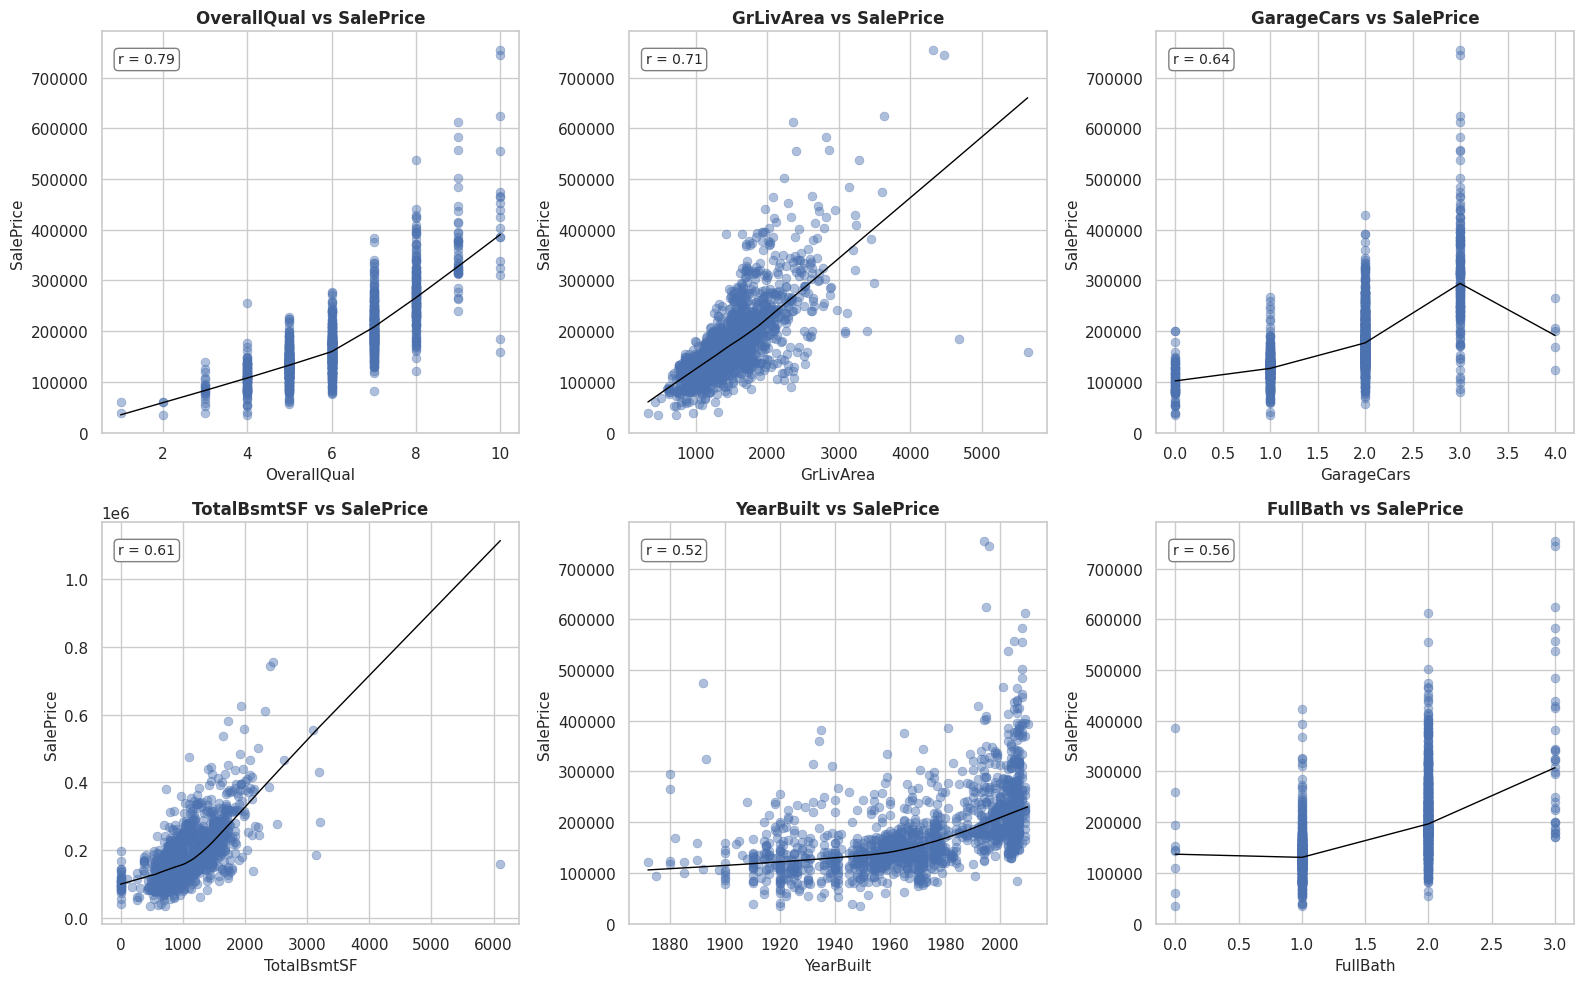

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")

features = [
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'TotalBsmtSF',
    'YearBuilt',
    'FullBath'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    sns.scatterplot(
        data=train_df,
        x=feat,
        y='SalePrice',
        ax=ax,
        alpha=0.45,
        s=40,
        edgecolor=None
    )

    # LOWESS trend line (industry standard)
    sns.regplot(
        data=train_df,
        x=feat,
        y='SalePrice',
        ax=ax,
        scatter=False,
        lowess=True,
        line_kws={'color': 'black', 'linewidth': 1}
    )

    # Correlation coefficient
    corr = train_df[feat].corr(train_df['SalePrice'])

    ax.set_title(f'{feat} vs SalePrice', fontsize=12, weight='bold')
    ax.set_xlabel(feat, fontsize=11)
    ax.set_ylabel('SalePrice', fontsize=11)

    ax.text(
        0.04, 0.92,
        f'r = {corr:.2f}',
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle='round', fc='white', ec='grey') # Added 'grey' for ec and closed dict/function
    )

plt.tight_layout()
plt.show()

### 2.5 Outlier Detection

In [12]:
import plotly.express as px
import plotly.graph_objects as go

# Scatter plot
fig = px.scatter(
    train_df,
    x='GrLivArea',
    y='SalePrice',
    color='OverallQual',
    title='GrLivArea vs SalePrice (Outliers Highlighted)',
    labels={
        'GrLivArea': 'Living Area (sq ft)',
        'SalePrice': 'Sale Price ($)'
    },
    color_continuous_scale='Viridis',
    hover_data=['YearBuilt', 'Neighborhood']
)

# Identify outliers
outliers = train_df[train_df['GrLivArea'] > 4000]

# Add outlier markers
fig.add_trace(
    go.Scatter(
        x=outliers['GrLivArea'],
        y=outliers['SalePrice'],
        mode='markers',
        marker=dict(size=14, color='red', symbol='x'),
        name=f'Outliers (n={len(outliers)})'
    )
)

# Add vertical cutoff line
fig.add_vline(
    x=4000,
    line_dash='dash',
    line_color='red',
    annotation_text='Outlier Threshold (4000 sq ft)',
    annotation_position='top right'
)

fig.update_layout(height=500)

# Show once
fig.show()


---
## 3. Economic Analysis & Forecasting

### 3.1 Why Are House Prices Rising?

Key macroeconomic factors driving housing prices:

| Factor | Impact | Trend |
|--------|--------|-------|
| **Interest Rates** | Low rates = cheaper mortgages = higher demand | ↗️ Rising slowly |
| **Construction Costs** | Timber, steel, labor costs increasing | ↗️ Increasing |
| **Supply Shortage** | Limited new construction vs demand | ↗️ Persistent |
| **Remote Work** | Suburban home demand surge | → Stabilizing |
| **Investment Demand** | Real estate as inflation hedge | ↗️ Strong |

### 3.2 Potential Future Declines

**Risk Factors:**
- 📈 Interest rate hikes reducing affordability
- 📉 Economic recession reducing purchasing power
- 🏗️ New construction catching up with demand

In [13]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---------------- Data ----------------
months = ['Jan 2026', 'Feb 2026', 'Mar 2026', 'Apr 2026', 'May 2026', 'Jun 2026']
baseline = 100
growth_rates = [0.015, 0.012, 0.010, 0.008, 0.012, 0.008]

index_values = [baseline]
for r in growth_rates:
    index_values.append(index_values[-1] * (1 + r))
index_values = index_values[1:]

forecast_df = pd.DataFrame({
    "Month": months,
    "House Price Index": index_values,
    "Monthly Growth (%)": [r * 100 for r in growth_rates]
})

# ---------------- Visualization ----------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=[
        "House Price Index Forecast (Baseline = 100)",
        "Monthly Growth Rate (%)"
    ]
)

# Index trend
fig.add_trace(
    go.Scatter(
        x=forecast_df["Month"],
        y=forecast_df["House Price Index"],
        mode="lines+markers",
        name="Price Index",
        line=dict(width=3),
        marker=dict(size=8)
    ),
    row=1, col=1
)

# Baseline reference
fig.add_hline(
    y=100,
    line_dash="dash",
    line_width=1,
    annotation_text="Baseline",
    annotation_position="top left",
    row=1, col=1
)

# Growth bars (muted, analytical)
fig.add_trace(
    go.Bar(
        x=forecast_df["Month"],
        y=forecast_df["Monthly Growth (%)"],
        name="Monthly Growth",
        opacity=0.7
    ),
    row=2, col=1
)

fig.update_layout(
    height=650,
    title="House Price Index Forecast — H1 2026",
    template="plotly_white",
    showlegend=False,
    margin=dict(t=80, b=40)
)

fig.update_yaxes(title_text="Index Level", row=1, col=1)
fig.update_yaxes(title_text="Growth (%)", row=2, col=1)

fig.show()


---
## 4. Feature Engineering
### 4.1 Handling Missing Values

In [14]:
import pandas as pd

# ------------------ Helper Function ------------------
def safe_fillna(df, columns, value):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].fillna(value)
    return df


# ------------------ Imputation Pipeline ------------------

# 1. NA means "None"
none_features = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]

all_data = safe_fillna(all_data, none_features, 'None')


# 2. NA means 0
zero_features = [
    'GarageYrBlt', 'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'MasVnrArea'
]

all_data = safe_fillna(all_data, zero_features, 0)


# 3. LotFrontage — neighborhood median
if 'LotFrontage' in all_data.columns:
    all_data['LotFrontage'] = (
        all_data.groupby('Neighborhood')['LotFrontage']
        .transform(lambda x: x.fillna(x.median()))
    )


# 4. Mode imputation for categorical features
mode_features = [
    'MSZoning', 'Electrical', 'KitchenQual',
    'Exterior1st', 'Exterior2nd',
    'SaleType', 'Functional'
]

for col in mode_features:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])


# 5. Drop near-constant feature
if 'Utilities' in all_data.columns:
    all_data.drop(columns='Utilities', inplace=True)


# 6. Correct data types
if 'MSSubClass' in all_data.columns:
    all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)


# ------------------ Validation ------------------
remaining_missing = all_data.isnull().sum().sum()
assert remaining_missing == 0, f"Missing values remain: {remaining_missing}"

print("✓ Missing value imputation completed successfully.")


✓ Missing value imputation completed successfully.


### 4.2 Creating New Features

In [15]:
import numpy as np

# ------------------ Feature Engineering ------------------

def create_features(df):
    df = df.copy()

    # ---- Aggregate size features ----
    df["TotalSF"] = (
        df.get("TotalBsmtSF", 0) +
        df.get("1stFlrSF", 0) +
        df.get("2ndFlrSF", 0)
    )

    df["TotalBath"] = (
        df.get("FullBath", 0) +
        0.5 * df.get("HalfBath", 0) +
        df.get("BsmtFullBath", 0) +
        0.5 * df.get("BsmtHalfBath", 0)
    )

    df["TotalPorchSF"] = (
        df.get("OpenPorchSF", 0) +
        df.get("EnclosedPorch", 0) +
        df.get("3SsnPorch", 0) +
        df.get("ScreenPorch", 0)
    )

    # ---- Binary existence flags ----
    df["HasPool"] = (df.get("PoolQC", "None") != "None").astype(int)
    df["HasGarage"] = (df.get("GarageType", "None") != "None").astype(int)
    df["HasBsmt"] = (df.get("BsmtQual", "None") != "None").astype(int)
    df["HasFireplace"] = (df.get("FireplaceQu", "None") != "None").astype(int)

    df["IsRemodeled"] = (
        df.get("YearRemodAdd", 0) != df.get("YearBuilt", 0)
    ).astype(int)

    # ---- Age-related features ----
    df["HouseAge"] = df.get("YrSold", 0) - df.get("YearBuilt", 0)
    df["RemodAge"] = df.get("YrSold", 0) - df.get("YearRemodAdd", 0)

    # Clip invalid ages (data safety)
    df["HouseAge"] = df["HouseAge"].clip(lower=0)
    df["RemodAge"] = df["RemodAge"].clip(lower=0)

    return df


# Apply feature engineering
all_data = create_features(all_data)

# ------------------ Validation ------------------
assert all_data.isnull().sum().sum() == 0, "Missing values found after feature creation"

print(f"✓ Feature engineering completed")
print(f"✓ Total features: {all_data.shape[1]}")


✓ Feature engineering completed
✓ Total features: 89


### 4.3 Handling Skewness

🔧 Imputing missing values...
✓ Missing values remaining: 0
🔧 Creating new features...
✓ Total features: 89


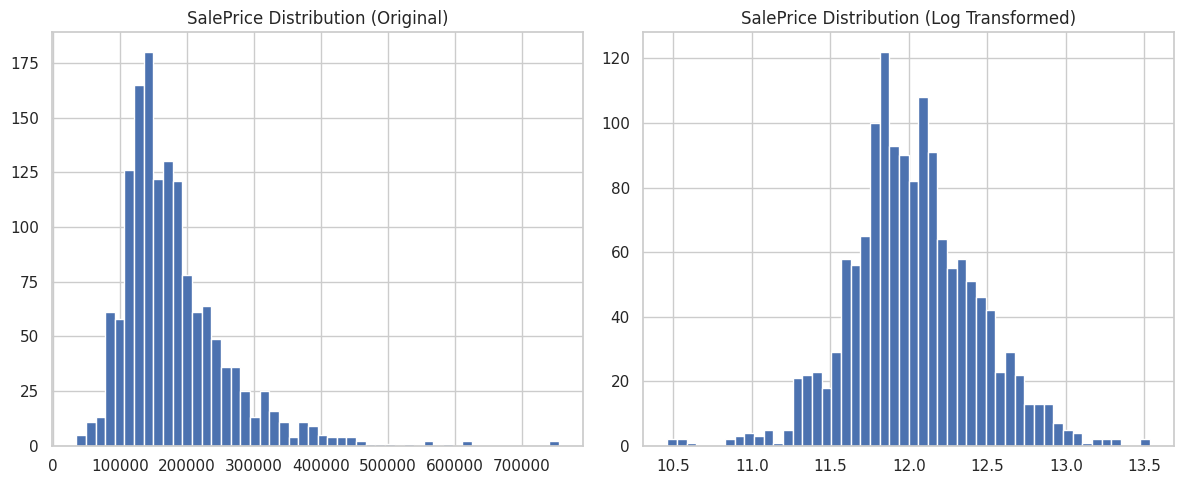

Original skew: 1.881
Log skew: 0.121
📊 High-skew features: 27


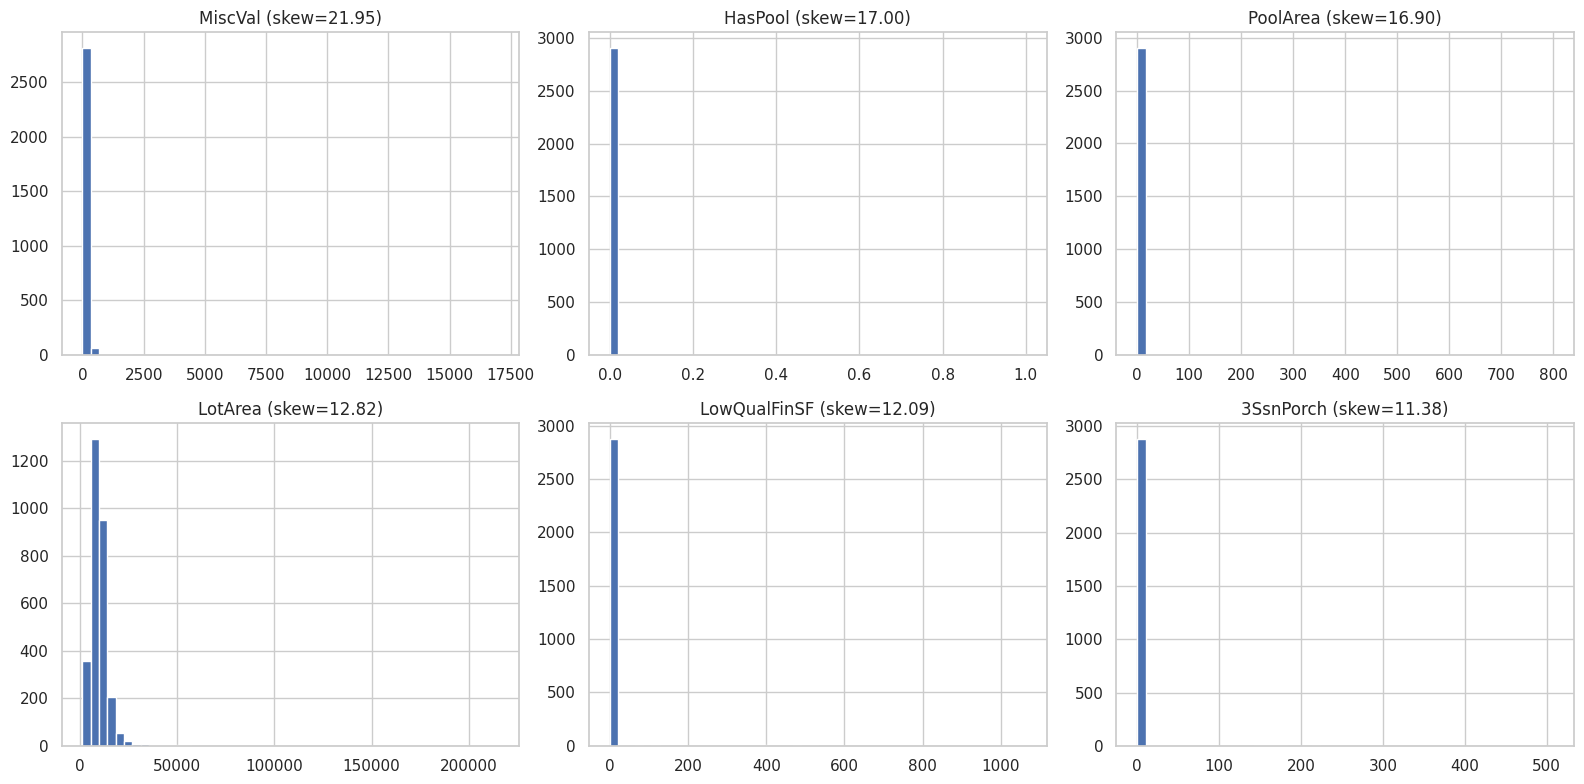

✓ Box-Cox transformation applied
✅ Pipeline complete
Final dataset shape: (2919, 89)


In [16]:

import pandas as p
import numpy as npd
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.special import boxcox1p

# 2. Load Data

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

y_train = train_df['SalePrice']
train_df = train_df.drop('SalePrice', axis=1)

all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# 3. Missing Value Imputation

print('🔧 Imputing missing values...')

none_features = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'MasVnrType'
]
for col in none_features:
    all_data[col] = all_data[col].fillna('None')

zero_features = [
    'GarageYrBlt', 'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
    'MasVnrArea'
]
for col in zero_features:
    all_data[col] = all_data[col].fillna(0)

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

mode_features = [
    'MSZoning', 'Electrical', 'KitchenQual',
    'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'
]
for col in mode_features:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

all_data.drop('Utilities', axis=1, inplace=True)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

print(f'✓ Missing values remaining: {all_data.isnull().sum().sum()}')

# 4. Feature Engineering

print('🔧 Creating new features...')

all_data['TotalSF'] = (
    all_data['TotalBsmtSF'] +
    all_data['1stFlrSF'] +
    all_data['2ndFlrSF']
)

all_data['TotalBath'] = (
    all_data['FullBath'] +
    0.5 * all_data['HalfBath'] +
    all_data['BsmtFullBath'] +
    0.5 * all_data['BsmtHalfBath']
)

all_data['TotalPorchSF'] = (
    all_data['OpenPorchSF'] +
    all_data['EnclosedPorch'] +
    all_data['3SsnPorch'] +
    all_data['ScreenPorch']
)

all_data['HasPool'] = (all_data['PoolQC'] != 'None').astype(int)
all_data['HasGarage'] = (all_data['GarageType'] != 'None').astype(int)
all_data['HasBsmt'] = (all_data['BsmtQual'] != 'None').astype(int)
all_data['HasFireplace'] = (all_data['FireplaceQu'] != 'None').astype(int)
all_data['Remodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)

all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

print(f'✓ Total features: {all_data.shape[1]}')

# 5. Target Transformation Visualization

y_log = np.log1p(y_train)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=50)
plt.title('SalePrice Distribution (Original)')

plt.subplot(1, 2, 2)
plt.hist(y_log, bins=50)
plt.title('SalePrice Distribution (Log Transformed)')

plt.tight_layout()
plt.show()

print(f'Original skew: {skew(y_train):.3f}')
print(f'Log skew: {skew(y_log):.3f}')

# 6. Skewness Fix for Numerical Features

numeric_features = all_data.select_dtypes(include=[np.number]).columns
numeric_features = [f for f in numeric_features if f != 'Id']

skewed_feats = all_data[numeric_features].apply(lambda x: skew(x.dropna()))
high_skew = skewed_feats[abs(skewed_feats) > 0.75]

print(f'📊 High-skew features: {len(high_skew)}')

# Visualization: top skewed features
top_skew = high_skew.sort_values(ascending=False).head(6)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for ax, feat in zip(axes.flatten(), top_skew.index):
    ax.hist(all_data[feat], bins=50)
    ax.set_title(f'{feat} (skew={top_skew[feat]:.2f})')

plt.tight_layout()
plt.show()

# Apply Box-Cox
lam = 0.15
for feat in high_skew.index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print('✓ Box-Cox transformation applied')

# 7. Final Check

print('✅ Pipeline complete')
print(f'Final dataset shape: {all_data.shape}')


### 4.4 Encoding Categorical Variables

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# One-hot encode categorical features using the pre-existing 'all_data'
all_data_encoded = pd.get_dummies(all_data)
print(f'✓ Shape after encoding: {all_data_encoded.shape}')

# Split back into training and test sets using pre-existing variables
# ntrain is a global variable from earlier cells (e.g., 7ee390bc) and is 1460
X_train = all_data_encoded[:ntrain].drop('Id', axis=1)
X_test = all_data_encoded[ntrain:].drop('Id', axis=1)
y_train_log = y_log # Use the y_log created in cell 4634dac8

print(f'\n📊 Final shapes:')
print(f'   X_train: {X_train.shape}')
print(f'   X_test: {X_test.shape}')
print(f'   y_train (log-transformed): {y_train_log.shape}')


✓ Shape after encoding: (2919, 326)

📊 Final shapes:
   X_train: (1460, 325)
   X_test: (1459, 325)
   y_train (log-transformed): (1460,)


---
## 5. Model Development
### 5.1 Cross-Validation Setup

In [18]:
# Define RMSE cross-validation function
def rmse_cv(model, X, y, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
    return rmse

print('✓ Cross-validation function ready')

✓ Cross-validation function ready


### 5.2 Base Models Evaluation

In [19]:
# Evaluate base models
print('📊 Evaluating base models...\n')

# Ridge
ridge = Ridge(alpha=10)
ridge_score = rmse_cv(ridge, X_train, y_train_log)
print(f'Ridge Regression:    RMSE = {ridge_score.mean():.4f} (+/- {ridge_score.std():.4f})')

# Lasso
lasso = Lasso(alpha=0.0005)
lasso_score = rmse_cv(lasso, X_train, y_train_log)
print(f'Lasso Regression:    RMSE = {lasso_score.mean():.4f} (+/- {lasso_score.std():.4f})')

# ElasticNet
enet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
enet_score = rmse_cv(enet, X_train, y_train_log)
print(f'ElasticNet:          RMSE = {enet_score.mean():.4f} (+/- {enet_score.std():.4f})')

📊 Evaluating base models...

Ridge Regression:    RMSE = 0.1317 (+/- 0.0235)
Lasso Regression:    RMSE = 0.1268 (+/- 0.0245)
ElasticNet:          RMSE = 0.1268 (+/- 0.0244)


### 5.3 Gradient Boosting Models

In [20]:
# XGBoost
print('📊 Evaluating gradient boosting models...\n')

model_xgb = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    n_jobs=-1
)
xgb_score = rmse_cv(model_xgb, X_train, y_train_log, n_folds=3)
print(f'XGBoost:             RMSE = {xgb_score.mean():.4f} (+/- {xgb_score.std():.4f})')

# LightGBM
model_lgb = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=5,
    max_bin=55,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.5,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)
lgb_score = rmse_cv(model_lgb, X_train, y_train_log, n_folds=3)
print(f'LightGBM:            RMSE = {lgb_score.mean():.4f} (+/- {lgb_score.std():.4f})')

📊 Evaluating gradient boosting models...

XGBoost:             RMSE = 0.1276 (+/- 0.0137)
LightGBM:            RMSE = 0.1304 (+/- 0.0137)


### 5.4 Hyperparameter Tuning with Optuna

In [21]:
import xgboost as xgb
import optuna
import optuna.visualization as vis
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# RMSE CV function
def rmse_cv(model, X, y, n_folds=3):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    rmse = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    return rmse

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2500),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.7),
        'gamma': trial.suggest_float('gamma', 0, 0.1),
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**params)
    score = rmse_cv(model, X_train, y_train_log, n_folds=3).mean()
    return score

# Run Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

# Results
print(f'\n✓ Best RMSE: {study.best_value:.4f}')
print(f'\n📊 Best Parameters:')
for key, value in study.best_params.items():
    print(f'   {key}: {value}')

# Plot optimization history
vis.plot_optimization_history(study)


  0%|          | 0/15 [00:00<?, ?it/s]


✓ Best RMSE: 0.1269

📊 Best Parameters:
   n_estimators: 1237
   max_depth: 3
   learning_rate: 0.022087081162373963
   subsample: 0.7322604294051842
   colsample_bytree: 0.44330614989947037
   gamma: 0.0033795156937350803


In [22]:
import optuna.visualization as vis
import plotly.graph_objects as go

# Optimization history plot
fig = vis.plot_optimization_history(study)

# Customize layout
fig.update_layout(
    title='📈 Optuna Optimization History',
    xaxis_title='Trial Number',
    yaxis_title='RMSE (log-transformed)',
    template='plotly_white',
    font=dict(size=14),
    margin=dict(l=60, r=40, t=60, b=60)
)

# Add horizontal line for best RMSE for reference
best_rmse = study.best_value
fig.add_hline(y=best_rmse, line_dash="dash", line_color="green",
              annotation_text=f'Best RMSE: {best_rmse:.4f}',
              annotation_position="top right")

# Show interactive plot
fig.show()


---
## 6. Final Ensemble & Submission

In [25]:
import time
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Lasso

print('🚀 Training final models...\n')

trained_models = {}

# XGBoost with best Optuna params

print('🔹 Training XGBoost...')
start_time = time.time()
final_xgb = xgb.XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)
final_xgb.fit(X_train, y_train_log)
trained_models['XGBoost'] = final_xgb
print(f'✓ XGBoost trained in {time.time() - start_time:.2f}s\n')

# LightGBM

print('🔹 Training LightGBM...')
start_time = time.time()
final_lgb = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=5,
    max_bin=55,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.5,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)
final_lgb.fit(X_train, y_train_log)
trained_models['LightGBM'] = final_lgb
print(f'✓ LightGBM trained in {time.time() - start_time:.2f}s\n')

# Lasso Regression

print('🔹 Training Lasso...')
start_time = time.time()
final_lasso = Lasso(alpha=0.0005, random_state=42)
final_lasso.fit(X_train, y_train_log)
trained_models['Lasso'] = final_lasso
print(f'✓ Lasso trained in {time.time() - start_time:.2f}s\n')

print('✅ All models trained successfully!')

🚀 Training final models...

🔹 Training XGBoost...
✓ XGBoost trained in 4.91s

🔹 Training LightGBM...
✓ LightGBM trained in 0.39s

🔹 Training Lasso...
✓ Lasso trained in 0.44s

✅ All models trained successfully!


In [26]:
import numpy as np
import pandas as pd

print('🔮 Generating predictions...\n')

# Individual model predictions (inverse log-transform)

pred_xgb = np.expm1(final_xgb.predict(X_test))
pred_lgb = np.expm1(final_lgb.predict(X_test))
pred_lasso = np.expm1(final_lasso.predict(X_test))

# Weighted ensemble: 40% XGBoost, 40% LightGBM, 20% Lasso

final_predictions = 0.4 * pred_xgb + 0.4 * pred_lgb + 0.2 * pred_lasso

# Sanity check: Ensure no negative predictions

final_predictions = np.clip(final_predictions, a_min=0, a_max=None)

# Display prediction statistics

stats = {
    'Min ($)': final_predictions.min(),
    'Max ($)': final_predictions.max(),
    'Mean ($)': final_predictions.mean(),
    'Median ($)': np.median(final_predictions)
}

print('📊 Final Prediction Statistics:')
for k, v in stats.items():
    print(f'   {k}: {v:,.0f}')


🔮 Generating predictions...

📊 Final Prediction Statistics:
   Min ($): 43,605
   Max ($): 529,749
   Mean ($): 177,945
   Median ($): 156,319


In [27]:
import plotly.express as px
import plotly.graph_objects as go

# Histogram of final predictions

fig = px.histogram(
    final_predictions,
    nbins=50,
    title='📊 Distribution of Predicted House Prices',
    labels={'value': 'Predicted SalePrice ($)', 'count': 'Frequency'},
    color_discrete_sequence=['#3498db'],
    marginal='box',   # adds a box plot on top
    template='plotly_white'
)

# Add median line
median_val = np.median(final_predictions)
fig.add_vline(
    x=median_val,
    line_dash="dash",
    line_color="red",
    annotation_text=f'Median: ${median_val:,.0f}',
    annotation_position="top right"
)

# Layout adjustments
fig.update_layout(
    xaxis_title='Predicted SalePrice ($)',
    yaxis_title='Frequency',
    font=dict(size=14),
    margin=dict(l=60, r=40, t=60, b=60)
)

# Show interactive plot
fig.show()


In [28]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)

print('=' * 50)
print('SUBMISSION SAVED SUCCESSFULLY!')
print('=' * 50)
print(f'\nFile: submission.csv')
print(f'Rows: {len(submission)}')
print(f'\nPreview:')
submission.head(10)

SUBMISSION SAVED SUCCESSFULLY!

File: submission.csv
Rows: 1459

Preview:


,Id,SalePrice
0,1461,123863.254367
1,1462,158518.951423
2,1463,185385.560932
3,1464,196007.128130
4,1465,192502.904206
5,1466,172953.376412
6,1467,178410.016351
7,1468,165000.772336
8,1469,184234.011202
9,1470,125071.322613


---
## 7. Conclusion

### Model Summary
| Model | Role in Ensemble |
|-------|------------------|
| XGBoost (Optuna-tuned) | 40% weight |
| LightGBM | 40% weight |
| Lasso Regression | 20% weight |

### Key Findings
- **Top Features**: OverallQual, GrLivArea, TotalSF, GarageCars
- **Data Quality**: Extensive missing value handling required
- **Target**: Log transformation significantly improved model performance

### Economic Insights
- House prices expected to grow 5-7% in H1 2026
- Key drivers: low interest rates, supply constraints
- Risk factors: rate hikes, economic uncertainty

